### 1. Install required packages

In [1]:
# devtools::install_github('reptalex/phylofactor')
# BiocManager::install("ggtree")
# BiocManager::install("DESeq2")
BiocManager::install("philr")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.18), R 4.1.2 (2021-11-01)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'philr'”
Old packages: 'aplot', 'brew', 'car', 'cli', 'commonmark', 'cpp11', 'crayon',
  'curl', 'data.table', 'datawizard', 'devtools', 'digest', 'DT', 'evaluate',
  'flextable', 'foreign', 'gert', 'ggforce', 'ggsignif', 'heatmaply', 'igraph',
  'insight', 'isoband', 'jsonlite', 'lifecycle', 'maptools', 'markdown',
  'mgcv', 'minqa', 'mnormt', 'network', 'nlme', 'nnet', 'openssl', 'polyclip',
  'psych', 'purrr', 'ragg', 'RcppArmadillo', 'RCurl', 'readr', 'rlang',
  'rmarkdown', 'RSQLite', 'shinyWidgets', 'stringi', 'sys', 'testthat',
  'tidyselect', 'tidytree', 'tinytex', 'vctrs', 'vegan', 'vroom', 'webshot',
  'xfun', 'XML', 'yaml'



### 2. Load required libraries

In [2]:
library(phylofactor)
library(ggtree)
library(phyloseq)
library(ggplot2)
library(DESeq2)
library(philr)

Loading required package: ape

Loading required package: magrittr

Warning message:
“package ‘magrittr’ was built under R version 4.1.3”
Loading required package: data.table

Loading required package: Matrix

Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun

ggtree v3.2.1  For help: https://yulab-smu.top/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

1. Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96
2. Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution. 2018, 35(12):3041-3043. doi:10.1093/molbev/msy194
3. Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam. ggtree: an R package for visualization and annotation of phylogenetic trees with their covariates and other a

#### 2a. Load R objects from diversity analyses

In [3]:
load("../02-diversity_analyses/.RData")
# load("domhain/2022-HIV_oral_microbiome/02-diversity_analyses/.RData")

### 3. Phylofactor analysis

#### 3a. First by study group

Warning message in PhyloFactor(asv_tab_diff, tree, x, nfactors = 3):
“Data has zeros and will receive default modification of zeros. Zeros will be replaced column wise with delta*min(x[x>0]), default delta=0.65”


pdf 
  2

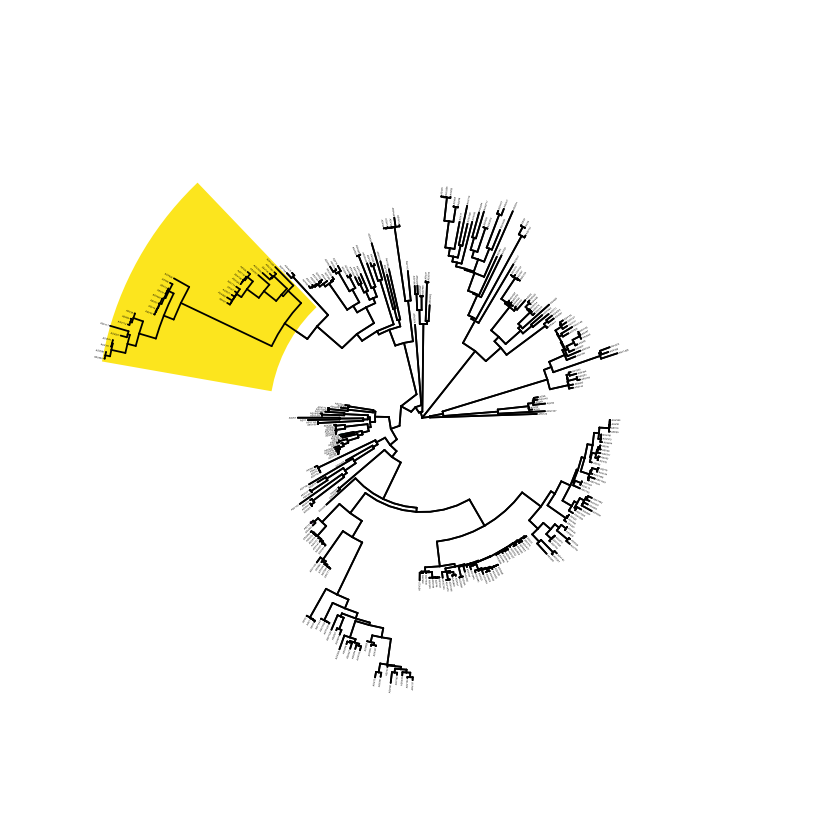

In [4]:
system("mkdir img")
asv_tab_diff <- as.matrix(t(read.table("../01-read_processing/sequence_table.filt.txt", header=T, sep="\t")))

# only DOMHaIN samples
filt.list <- grep(colnames(asv_tab_diff), pattern="DM", value=T)
asv_tab_diff <- asv_tab_diff[,colnames(asv_tab_diff) %in% filt.list]
filtmap <- metadata[rownames(metadata) %in% filt.list,]
filtmap <- filtmap[match(filt.list, rownames(filtmap)),]

x <- as.factor(filtmap$study_group) # variable of interest
tree <- phy_tree(philr.dat)
tax <- tax_table(philr.dat)
common.asvs <- which(rowSums(asv_tab_diff>0)>50)
asv_tab_diff <- asv_tab_diff[common.asvs,]
tree <- ape::drop.tip(tree, setdiff(tree$tip.label, rownames(asv_tab_diff)))
pf <- PhyloFactor(asv_tab_diff, tree, x, nfactors=3)
pf$Data <- pf$Data[pf$tree$tip.label,]
gtree <- pf.tree(pf)
pdf("img/phylofactor_tree.study_group.pdf")
gtree$ggplot + geom_tiplab(size=0.5)
dev.off()
gtree$ggplot + geom_tiplab(size=0.5)

Factor 1 boxplots

pdf 
  2

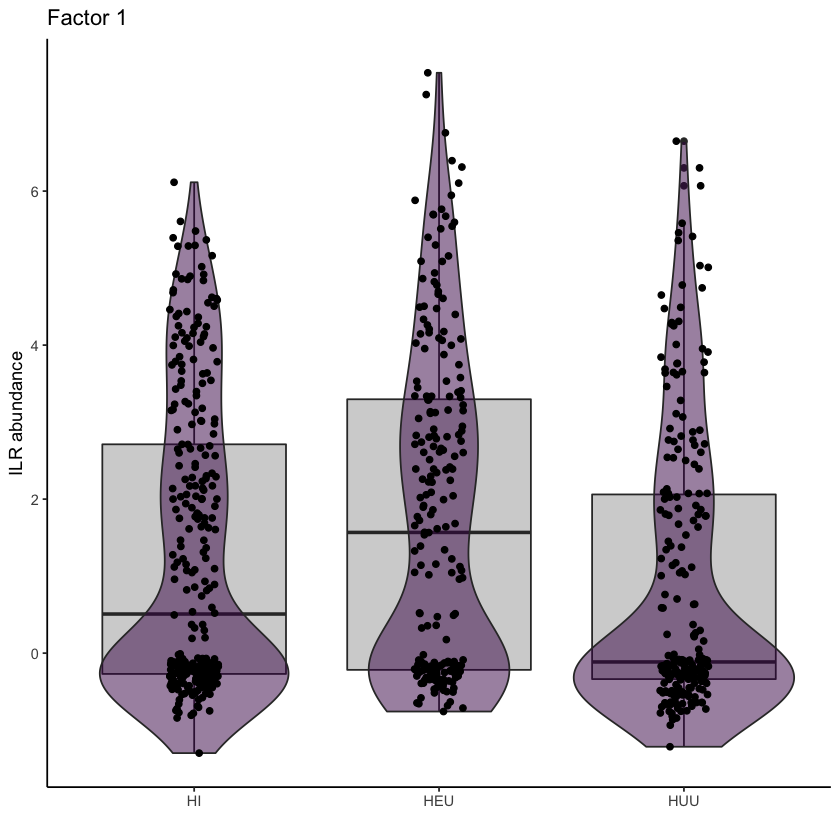

In [5]:
levs <- c("HI", "HEU", "HUU")
y <- t(pf$basis[,1]) %*% log(pf$Data)
dat <- as.data.frame(cbind(as.matrix(pf$X), (t(y))))
dat$V2 <- as.numeric(as.character(dat$V2))
bplt <- ggplot(dat, aes(x=factor(V1, level=levs), y=V2)) + geom_boxplot(fill="light grey") + geom_violin(fill=gtree$legend$colors[1], alpha=0.5) + geom_jitter(position=position_jitter(width=0.1)) + theme_classic() + ylab("ILR abundance") + xlab("") + ggtitle('Factor 1')
bplt
pdf("img/factor1_boxp.study_group.pdf")
bplt
dev.off()

Significance

In [6]:
# significance (this is ugly code but it gets the job done)
levels <- t(combn(levels(as.factor(dat$V1)), 2))
for(row in 1:nrow(levels)){
   for(col in 1:ncol(levels)){
      for(row1 in 1:nrow(levels)){
         for(col2 in 2:ncol(levels)){
            p <- wilcox.test(dat[dat$V1 == levels[row,col],]$V2, dat[dat$V1 == levels[row1,col2],]$V2)
               if(p$p.value <= 0.05){
                  print(paste0(levels[row,col], " vs ", levels[row1,col2], ": p=", p$p.value, " W=", p$statistic))
               }
         }
      }

   }
}

[1] "HEU vs HI: p=0.015665033401107 W=37007"
[1] "HEU vs HUU: p=1.39117529798392e-06 W=32506"
[1] "HEU vs HUU: p=1.39117529798392e-06 W=32506"
[1] "HI vs HUU: p=0.00423391930861931 W=38730"
[1] "HI vs HUU: p=0.00423391930861931 W=38730"
[1] "HEU vs HI: p=0.015665033401107 W=37007"
[1] "HEU vs HUU: p=1.39117529798392e-06 W=32506"
[1] "HEU vs HUU: p=1.39117529798392e-06 W=32506"
[1] "HUU vs HI: p=0.00423391930861931 W=28890"
[1] "HI vs HUU: p=0.00423391930861931 W=38730"
[1] "HI vs HUU: p=0.00423391930861931 W=38730"
[1] "HUU vs HI: p=0.00423391930861931 W=28890"


Factor 2

pdf 
  2

[1] "HI vs HUU: p=0.00107078984453791 W=39437"
[1] "HI vs HUU: p=0.00107078984453791 W=39437"
[1] "HUU vs HI: p=0.00107078984453791 W=28183"
[1] "HI vs HUU: p=0.00107078984453791 W=39437"
[1] "HI vs HUU: p=0.00107078984453791 W=39437"
[1] "HUU vs HI: p=0.00107078984453791 W=28183"


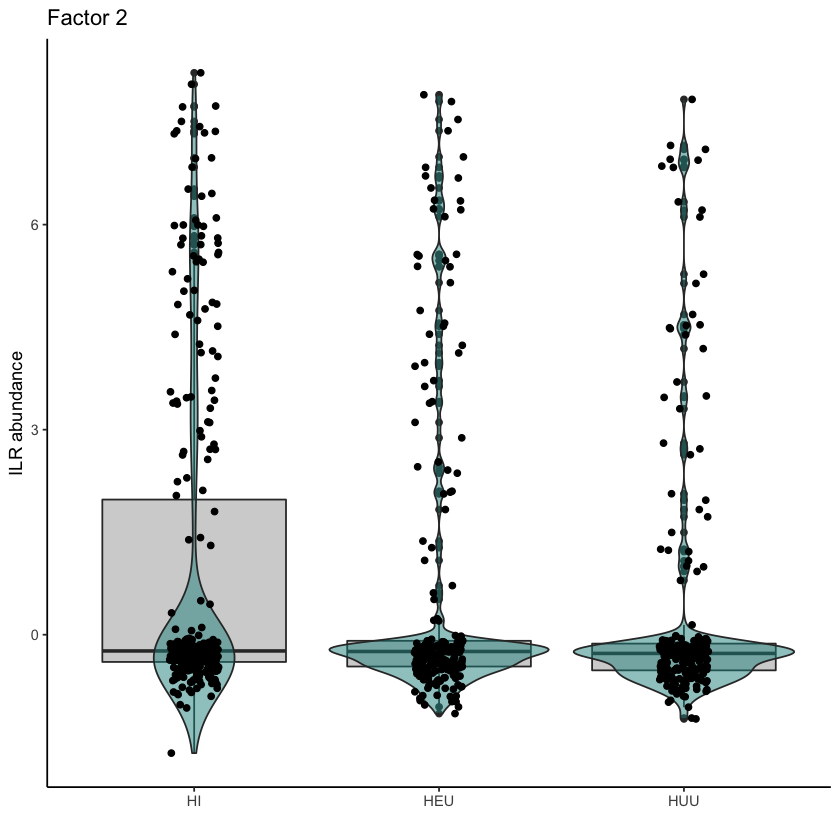

In [7]:
y <- t(pf$basis[,2]) %*% log(pf$Data)
dat <- as.data.frame(cbind(as.matrix(pf$X), (t(y))))
dat$V2 <- as.numeric(as.character(dat$V2))
bplt <- ggplot(dat, aes(x=factor(V1, level=levs), y=V2)) + geom_boxplot(fill="light grey") + geom_violin(fill=gtree$legend$colors[2], alpha=0.5) + geom_jitter(position=position_jitter(width=0.1)) + theme_classic() + ylab("ILR abundance") + xlab("") + ggtitle('Factor 2') 
bplt
pdf("img/factor2_boxp.study_group.pdf")
bplt
dev.off()

# significance
levels <- t(combn(levels(as.factor(dat$V1)), 2))
for(row in 1:nrow(levels)){
   for(col in 1:ncol(levels)){
      for(row1 in 1:nrow(levels)){
         for(col2 in 2:ncol(levels)){
            p <- wilcox.test(dat[dat$V1 == levels[row,col],]$V2, dat[dat$V1 == levels[row1,col2],]$V2)
               if(p$p.value <= 0.05){
                  print(paste0(levels[row,col], " vs ", levels[row1,col2], ": p=", p$p.value, " W=", p$statistic))
               }
         }
      }

   }
}

Factor 3

pdf 
  2

[1] "HEU vs HI: p=0.000724649908411618 W=38633"
[1] "HEU vs HUU: p=0.0246881996173597 W=28900"
[1] "HEU vs HUU: p=0.0246881996173597 W=28900"
[1] "HEU vs HI: p=0.000724649908411618 W=38633"
[1] "HEU vs HUU: p=0.0246881996173597 W=28900"
[1] "HEU vs HUU: p=0.0246881996173597 W=28900"


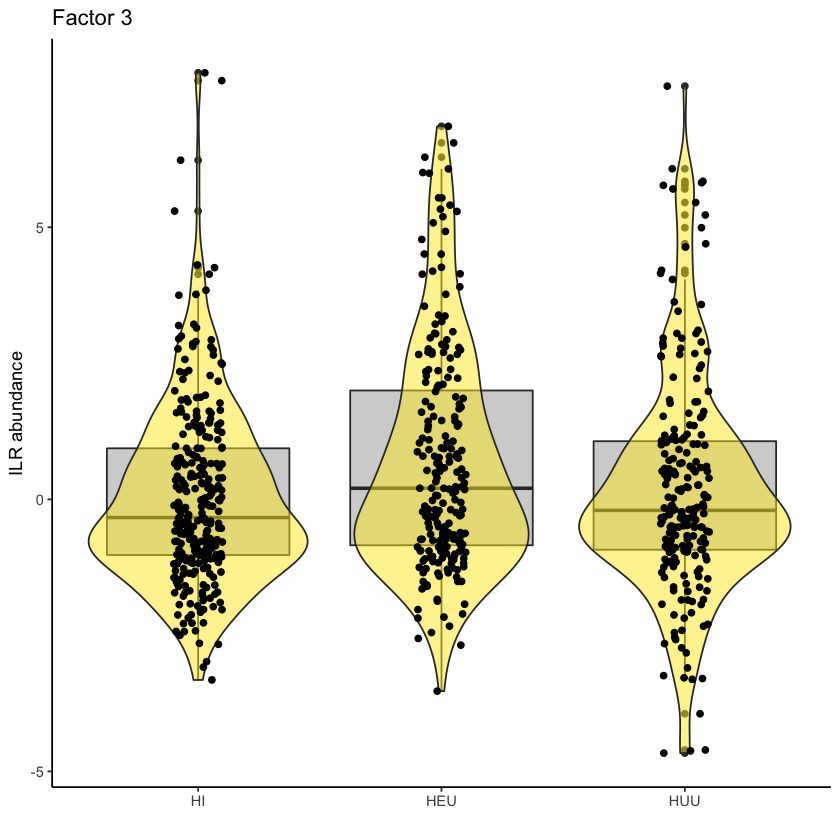

In [8]:
y <- t(pf$basis[,3]) %*% log(pf$Data)
dat <- as.data.frame(cbind(as.matrix(pf$X), (t(y))))
dat$V2 <- as.numeric(as.character(dat$V2))
bplt <- ggplot(dat, aes(x=factor(V1, level=levs), y=V2)) + geom_boxplot(fill="light grey") + geom_violin(fill=gtree$legend$colors[3], alpha=0.5) + geom_jitter(position=position_jitter(width=0.1)) + theme_classic() + ylab("ILR abundance") + xlab("") + ggtitle('Factor 3')
bplt 
pdf("img/factor3_boxp.study_group.pdf")
bplt
dev.off()

# significance
levels <- t(combn(levels(as.factor(dat$V1)), 2))
for(row in 1:nrow(levels)){
   for(col in 1:ncol(levels)){
      for(row1 in 1:nrow(levels)){
         for(col2 in 2:ncol(levels)){
            p <- wilcox.test(dat[dat$V1 == levels[row,col],]$V2, dat[dat$V1 == levels[row1,col2],]$V2)
               if(p$p.value <= 0.05){
                  print(paste0(levels[row,col], " vs ", levels[row1,col2], ": p=", p$p.value, " W=", p$statistic))
               }
         }
      }

   }
}

#### 3b. By aliquot type

Warning message in PhyloFactor(asv_tab_diff, tree, x, nfactors = 3):
“Data has zeros and will receive default modification of zeros. Zeros will be replaced column wise with delta*min(x[x>0]), default delta=0.65”


pdf 
  2

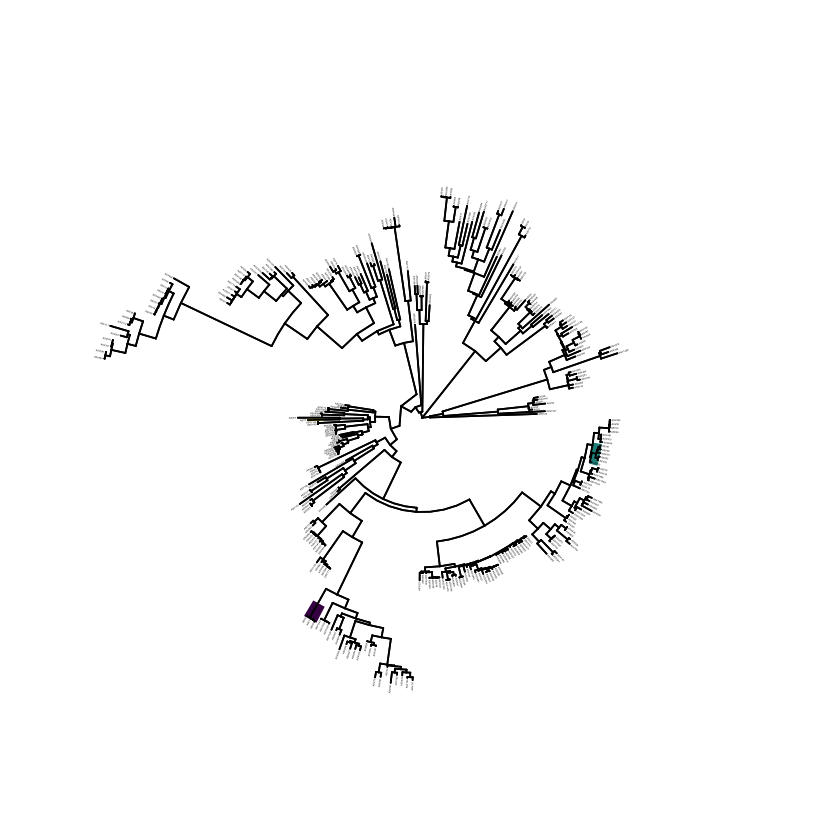

In [9]:
x <- as.factor(filtmap$aliquot_type) # variable of interest
tree <- phy_tree(philr.dat)
tax <- tax_table(philr.dat)
common.asvs <- which(rowSums(asv_tab_diff>0)>50)
asv_tab_diff <- asv_tab_diff[common.asvs,]
tree <- ape::drop.tip(tree, setdiff(tree$tip.label, rownames(asv_tab_diff)))
pf <- PhyloFactor(asv_tab_diff, tree, x, nfactors=3)
pf$Data <- pf$Data[pf$tree$tip.label,]
gtree <- pf.tree(pf)
pdf("img/phylofactor_tree.aliquot_type.pdf")
gtree$ggplot + geom_tiplab(size=0.5)
dev.off()
gtree$ggplot + geom_tiplab(size=0.5)

Factor 1

pdf 
  2

[1] "CA-PD vs CA-PE: p=0.000307310236269425 W=3534"
[1] "CA-PD vs CA-PF: p=2.31894614749588e-09 W=8207"
[1] "CA-PD vs CAE-PE: p=0.0148350663090476 W=1250"
[1] "CA-PD vs CAE-PF: p=2.47453347443393e-07 W=4003"
[1] "CA-PD vs CF-PF: p=2.79810187500875e-15 W=31918"
[1] "CA-PD vs CA-PF: p=2.31894614749588e-09 W=8207"
[1] "CA-PD vs CAE-PE: p=0.0148350663090476 W=1250"
[1] "CA-PD vs CAE-PF: p=2.47453347443393e-07 W=4003"
[1] "CA-PD vs CF-PF: p=2.79810187500875e-15 W=31918"
[1] "CA-PD vs CAE-PE: p=0.0148350663090476 W=1250"
[1] "CA-PD vs CAE-PF: p=2.47453347443393e-07 W=4003"
[1] "CA-PD vs CF-PF: p=2.79810187500875e-15 W=31918"
[1] "CA-PD vs CAE-PF: p=2.47453347443393e-07 W=4003"
[1] "CA-PD vs CF-PF: p=2.79810187500875e-15 W=31918"
[1] "CA-PD vs CF-PF: p=2.79810187500875e-15 W=31918"
[1] "CA-PD vs CA-PE: p=0.000307310236269425 W=3534"
[1] "CA-PD vs CA-PF: p=2.31894614749588e-09 W=8207"
[1] "CA-PD vs CAE-PE: p=0.0148350663090476 W=1250"
[1] "CA-PD vs CAE-PF: p=2.47453347443393e-07 W=4003"
[1] "C

Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”


[1] "CA-PD vs CA-PE: p=0.000307310236269425 W=3534"
[1] "CA-PD vs CA-PF: p=2.31894614749588e-09 W=8207"
[1] "CA-PD vs CAE-PE: p=0.0148350663090476 W=1250"
[1] "CA-PD vs CAE-PF: p=2.47453347443393e-07 W=4003"
[1] "CA-PD vs CF-PF: p=2.79810187500875e-15 W=31918"
[1] "CA-PD vs CA-PF: p=2.31894614749588e-09 W=8207"
[1] "CA-PD vs CAE-PE: p=0.0148350663090476 W=1250"
[1] "CA-PD vs CAE-PF: p=2.47453347443393e-07 W=4003"
[1] "CA-PD vs CF-PF: p=2.79810187500875e-15 W=31918"
[1] "CA-PD vs CAE-PE: p=0.0148350663090476 W=1250"
[1] "CA-PD vs CAE-PF: p=2.47453347443393e-07 W=4003"
[1] "CA-PD vs CF-PF: p=2.79810187500875e-15 W=31918"
[1] "CA-PD vs CAE-PF: p=2.47453347443393e-07 W=4003"
[1] "CA-PD vs CF-PF: p=2.79810187500875e-15 W=31918"
[1] "CA-PD vs CF-PF: p=2.79810187500875e-15 W=31918"
[1] "CA-PD vs CA-PE: p=0.000307310236269425 W=3534"
[1] "CA-PD vs CA-PF: p=2.31894614749588e-09 W=8207"
[1] "CA-PD vs CAE-PE: p=0.0148350663090476 W=1250"
[1] "CA-PD vs CAE-PF: p=2.47453347443393e-07 W=4003"
[1] "C

Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[ro

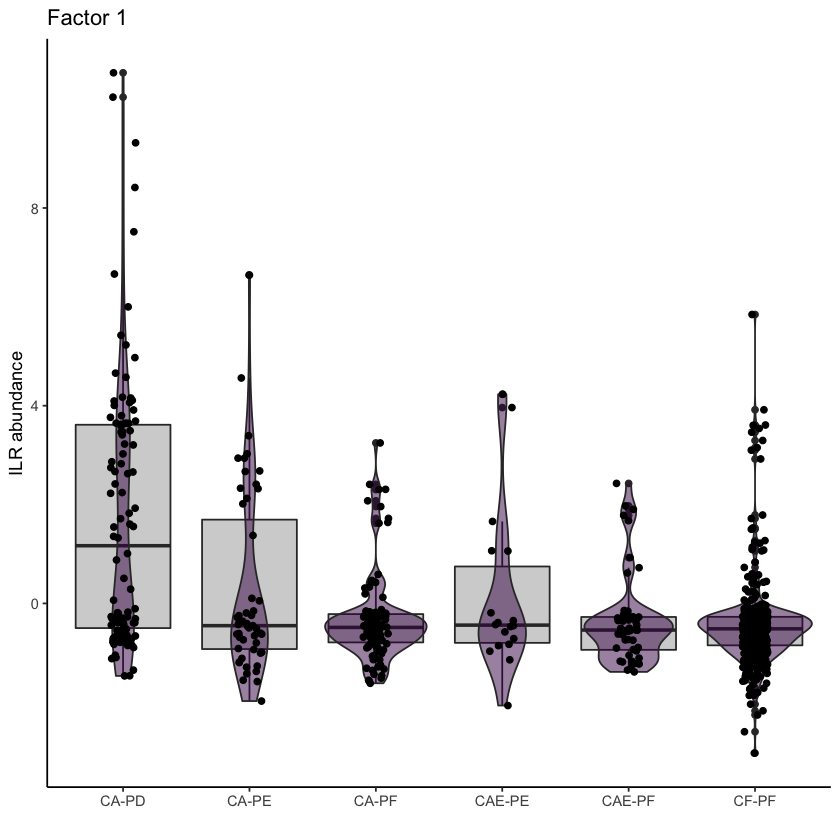

In [10]:
levs <- c("CA-PD", "CA-PE", "CA-PF", "CAE-PE", "CAE-PF", "CF-PF")
y <- t(pf$basis[,1]) %*% log(pf$Data)
dat <- as.data.frame(cbind(as.matrix(pf$X), (t(y))))
dat$V2 <- as.numeric(as.character(dat$V2))
bplt <- ggplot(dat, aes(x=factor(V1, level=levs), y=V2)) + geom_boxplot(fill="light grey") + geom_violin(fill=gtree$legend$colors[1], alpha=0.5) + geom_jitter(position=position_jitter(width=0.1)) + theme_classic() + ylab("ILR abundance") + xlab("") + ggtitle('Factor 1')
bplt
pdf("img/factor1_boxp.aliquot_type.pdf")
bplt
dev.off()

# significance
levels <- t(combn(levels(as.factor(dat$V1)), 2))
for(row in 1:nrow(levels)){
   for(col in 1:ncol(levels)){
      for(row1 in 1:nrow(levels)){
         for(col2 in 2:ncol(levels)){
            p <- wilcox.test(dat[dat$V1 == levels[row,col],]$V2, dat[dat$V1 == levels[row1,col2],]$V2)
               if(p$p.value <= 0.05){
                  print(paste0(levels[row,col], " vs ", levels[row1,col2], ": p=", p$p.value, " W=", p$statistic))
               }
         }
      }

   }
}

Factor 2

pdf 
  2

[1] "CA-PD vs CA-PF: p=0.0437934780880675 W=6453"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CA-PF: p=0.0437934780880675 W=6453"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs C

Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”


[1] "CA-PD vs CA-PF: p=0.0437934780880675 W=6453"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CA-PF: p=0.0437934780880675 W=6453"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CAE-PF vs CA-PE: p=0.0356534623924598 W=1007"
[1] "CA-PD vs CA-PF: p=0.0437934780880675 W=6453"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CA-PF: p=0.0437934780880675 W=6453"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA

Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”


[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CAE-PF vs CA-PE: p=0.0356534623924598 W=1007"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CF-PF vs CA-PE: p=0.031312

Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”


[1] "CAE-PF vs CA-PE: p=0.0356534623924598 W=1007"
[1] "CF-PF vs CA-PE: p=0.0313126441400006 W=8649"


Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”


[1] "CAE-PF vs CA-PE: p=0.0356534623924598 W=1007"


Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”


[1] "CF-PF vs CA-PE: p=0.0313126441400006 W=8649"
[1] "CAE-PF vs CA-PE: p=0.0356534623924598 W=1007"
[1] "CF-PF vs CA-PE: p=0.0313126441400006 W=8649"


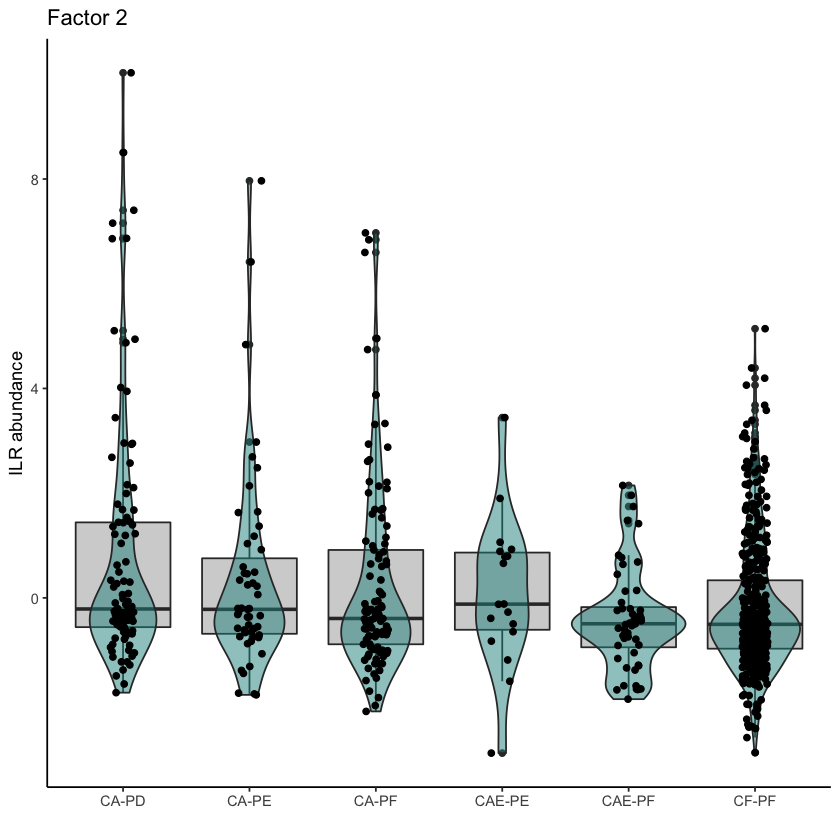

In [11]:
y <- t(pf$basis[,2]) %*% log(pf$Data)
dat <- as.data.frame(cbind(as.matrix(pf$X), (t(y))))
dat$V2 <- as.numeric(as.character(dat$V2))
bplt <- ggplot(dat, aes(x=factor(V1, level=levs), y=V2)) + geom_boxplot(fill="light grey") + geom_violin(fill=gtree$legend$colors[2], alpha=0.5) + geom_jitter(position=position_jitter(width=0.1)) + theme_classic() + ylab("ILR abundance") + xlab("") + ggtitle('Factor 2')
bplt
pdf("img/factor2_boxp.aliquot_type.pdf")
bplt
dev.off()

# significance
levels <- t(combn(levels(as.factor(dat$V1)), 2))
for(row in 1:nrow(levels)){
   for(col in 1:ncol(levels)){
      for(row1 in 1:nrow(levels)){
         for(col2 in 2:ncol(levels)){
            p <- wilcox.test(dat[dat$V1 == levels[row,col],]$V2, dat[dat$V1 == levels[row1,col2],]$V2)
               if(p$p.value <= 0.05){
                  print(paste0(levels[row,col], " vs ", levels[row1,col2], ": p=", p$p.value, " W=", p$statistic))
               }
         }
      }

   }
}

Factor 3

pdf 
  2

[1] "CA-PD vs CA-PF: p=0.0437934780880675 W=6453"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CA-PF: p=0.0437934780880675 W=6453"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs C

Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”


[1] "CA-PD vs CA-PF: p=0.0437934780880675 W=6453"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CA-PF: p=0.0437934780880675 W=6453"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CAE-PF vs CA-PE: p=0.0356534623924598 W=1007"
[1] "CA-PD vs CA-PF: p=0.0437934780880675 W=6453"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CA-PF: p=0.0437934780880675 W=6453"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA-PD vs CF-PF: p=8.61271004348587e-06 W=27244"
[1] "CA-PD vs CAE-PF: p=0.000418309612968328 W=3576"
[1] "CA

Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”


[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CAE-PF vs CA-PE: p=0.0356534623924598 W=1007"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CAE-PF: p=0.0356534623924598 W=1645"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CA-PE vs CF-PF: p=0.0313126441400006 W=12567"
[1] "CF-PF vs CA-PE: p=0.031312

Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”


[1] "CAE-PF vs CA-PE: p=0.0356534623924598 W=1007"
[1] "CF-PF vs CA-PE: p=0.0313126441400006 W=8649"


Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”


[1] "CAE-PF vs CA-PE: p=0.0356534623924598 W=1007"


Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(dat[dat$V1 == levels[row, col], ]$V2, dat[dat$V1 == :
“cannot compute exact p-value with ties”


[1] "CF-PF vs CA-PE: p=0.0313126441400006 W=8649"
[1] "CAE-PF vs CA-PE: p=0.0356534623924598 W=1007"
[1] "CF-PF vs CA-PE: p=0.0313126441400006 W=8649"


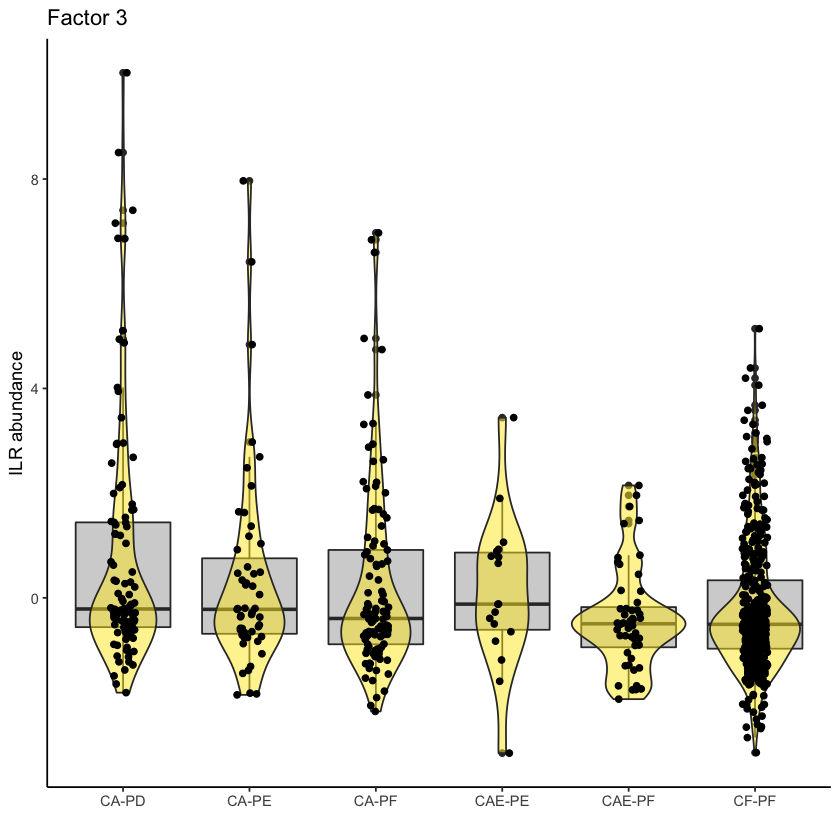

In [12]:
y <- t(pf$basis[,2]) %*% log(pf$Data)
dat <- as.data.frame(cbind(as.matrix(pf$X), (t(y))))
dat$V2 <- as.numeric(as.character(dat$V2))
bplt <- ggplot(dat, aes(x=factor(V1, level=levs), y=V2)) + geom_boxplot(fill="light grey") + geom_violin(fill=gtree$legend$colors[3], alpha=0.5) + geom_jitter(position=position_jitter(width=0.1)) + theme_classic() + ylab("ILR abundance") + xlab("") + ggtitle('Factor 3')
bplt
pdf("img/factor3_boxp.aliquot_type.pdf")
bplt
dev.off()

# significance
levels <- t(combn(levels(as.factor(dat$V1)), 2))
for(row in 1:nrow(levels)){
   for(col in 1:ncol(levels)){
      for(row1 in 1:nrow(levels)){
         for(col2 in 2:ncol(levels)){
            p <- wilcox.test(dat[dat$V1 == levels[row,col],]$V2, dat[dat$V1 == levels[row1,col2],]$V2)
               if(p$p.value <= 0.05){
                  print(paste0(levels[row,col], " vs ", levels[row1,col2], ": p=", p$p.value, " W=", p$statistic))
               }
         }
      }

   }
}

### 4. DESeq2

In [13]:
# subset samples to only include HI and HUU CF-PF
cfpf <- subset_samples(ps.dat.noUS, aliquot_study == "HI.CF-PF" | aliquot_study == "HUU.CF-PF")
sample_data(cfpf)$aliquot_study <- as.factor(sample_data(cfpf)$aliquot_study)
difabund <- phyloseq_to_deseq2(cfpf, ~ aliquot_study)

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans <- apply(counts(difabund), 1, gm_mean)
difabund <- estimateSizeFactors(difabund, geoMeans = geoMeans)
res <- DESeq(difabund, fitType="local")

sigtab <- results(res)
sigtab <- sigtab[order(sigtab$padj, na.last = NA),]
sigtab <- sigtab[(sigtab$padj < 0.05),]
sigtab <- cbind(as(sigtab, "data.frame"), as(tax_table(cfpf)[rownames(sigtab),], "matrix"))
sigtab

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column nam

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ASV48,4.759455,-25.16062,2.891319,-8.702125,3.257251e-18,8.533997e-15,Bacteria,FCB_group,Bacteroidetes/Chlorobi_group,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella_oralis,Prevotella_oralis_unknown,Prevotella_oralis_unknown


Plot results

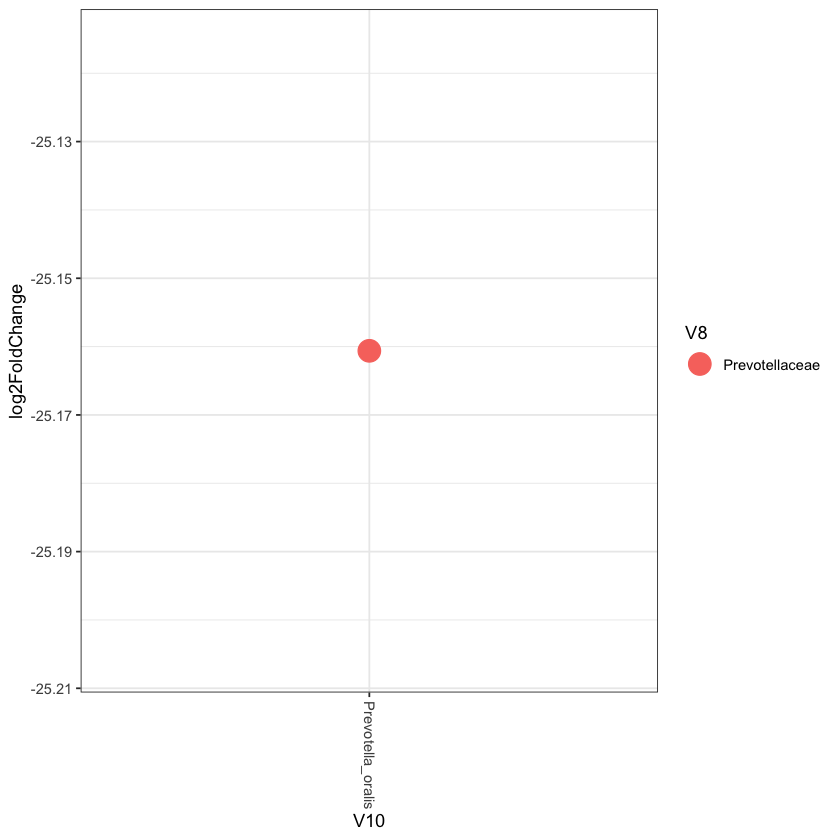

In [14]:
theme_set(theme_bw())
scale_fill_discrete <- function(palname = "Set1", ...) {
    scale_fill_brewer(palette = palname, ...)
}
# Phylum order
x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
# Genus order
x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V8)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))

In [15]:
cfpf <- subset_samples(ps.dat.noUS, aliquot_study == "HI.CF-PF" | aliquot_study == "HEU.CF-PF")
sample_data(cfpf)$aliquot_study <- as.factor(sample_data(cfpf)$aliquot_study)
difabund <- phyloseq_to_deseq2(cfpf, ~ aliquot_study)

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans <- apply(counts(difabund), 1, gm_mean)
difabund <- estimateSizeFactors(difabund, geoMeans = geoMeans)
res <- DESeq(difabund, fitType="local")

sigtab <- results(res)
sigtab <- sigtab[order(sigtab$padj, na.last = NA),]
sigtab <- sigtab[(sigtab$padj < 0.05),]
sigtab <- cbind(as(sigtab, "data.frame"), as(tax_table(cfpf)[rownames(sigtab),], "matrix"))
sigtab

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column nam

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ASV150,10.384670,-26.12321,1.886049,-13.850757,1.258780e-43,3.337025e-40,Bacteria,FCB_group,Bacteroidetes/Chlorobi_group,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Capnocytophaga,Capnocytophaga_gingivalis,Capnocytophaga_gingivalis_unknown,Capnocytophaga_gingivalis_unknown
ASV71,13.978809,-26.15632,2.898233,-9.024918,1.798295e-19,2.383640e-16,Bacteria,Fusobacteria,Fusobacteriia,Fusobacteriales,Leptotrichiaceae,Leptotrichia,unclassified_Leptotrichia,Leptotrichia_sp._oral_taxon_417,Leptotrichia_sp._oral_taxon_417_unknown,Leptotrichia_sp._oral_taxon_417_unknown,Leptotrichia_sp._oral_taxon_417_unknown
ASV120,8.086232,25.32706,2.897574,8.740783,2.315009e-18,2.045696e-15,Bacteria,Terrabacteria_group,Actinobacteria,Actinomycetia,Corynebacteriales,Corynebacteriaceae,Corynebacterium,Corynebacterium_matruchotii,Corynebacterium_matruchotii_ATCC_33806,Corynebacterium_matruchotii_ATCC_33806_unknown,Corynebacterium_matruchotii_ATCC_33806_unknown


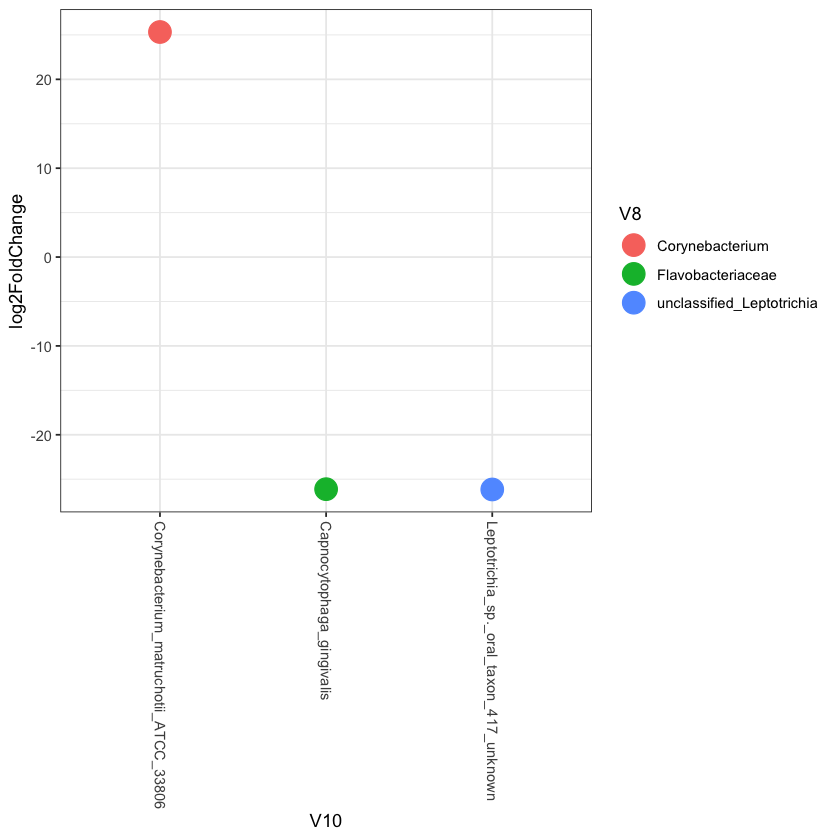

In [16]:
theme_set(theme_bw())
scale_fill_discrete <- function(palname = "Set1", ...) {
    scale_fill_brewer(palette = palname, ...)
}
# Phylum order
x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
# Genus order
x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V8)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))

In [17]:
cfpf <- subset_samples(ps.dat.noUS, aliquot_study == "HEU.CF-PF" | aliquot_study == "HUU.CF-PF")
sample_data(cfpf)$aliquot_study <- as.factor(sample_data(cfpf)$aliquot_study)
difabund <- phyloseq_to_deseq2(cfpf, ~ aliquot_study)

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans <- apply(counts(difabund), 1, gm_mean)
difabund <- estimateSizeFactors(difabund, geoMeans = geoMeans)
res <- DESeq(difabund, fitType="local")

sigtab <- results(res)
sigtab <- sigtab[order(sigtab$padj, na.last = NA),]
sigtab <- sigtab[(sigtab$padj < 0.05),]
# sigtab <- cbind(as(sigtab, "data.frame"), as(tax_table(cfpf)[rownames(sigtab),], "matrix"))
sigtab # no significant differences

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column nam

log2 fold change (MLE): aliquot study HUU.CF.PF vs HEU.CF.PF 
Wald test p-value: aliquot study HUU.CF.PF vs HEU.CF.PF 
DataFrame with 0 rows and 6 columns

In [18]:
capd <- subset_samples(ps.dat.noUS, aliquot_study == "HI.CA-PD" | aliquot_study == "HUU.CA-PD")
sample_data(capd)$aliquot_study <- as.factor(sample_data(capd)$aliquot_study)
difabund <- phyloseq_to_deseq2(capd, ~ aliquot_study)

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans <- apply(counts(difabund), 1, gm_mean)
difabund <- estimateSizeFactors(difabund, geoMeans = geoMeans)
res <- DESeq(difabund, fitType="local")

sigtab <- results(res)
sigtab <- sigtab[order(sigtab$padj, na.last = NA),]
sigtab <- sigtab[(sigtab$padj < 0.05),]
sigtab <- cbind(as(sigtab, "data.frame"), as(tax_table(cfpf)[rownames(sigtab),], "matrix"))
sigtab

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column nam

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ASV23,26.579076,-23.90509,2.066089,-11.570214,5.833689e-31,3.161859e-28,Bacteria,Fusobacteria,Fusobacteriia,Fusobacteriales,Leptotrichiaceae,Leptotrichia,unclassified_Leptotrichia,Leptotrichia_sp._oral_taxon_498,Leptotrichia_sp._oral_taxon_498_unknown,Leptotrichia_sp._oral_taxon_498_unknown,Leptotrichia_sp._oral_taxon_498_unknown
ASV198,11.832316,-23.46447,2.553982,-9.187408,4.024195e-20,1.090557e-17,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,Neisseria_perflava,Neisseria_perflava_unknown,Neisseria_perflava_unknown,Neisseria_perflava_unknown,Neisseria_perflava_unknown
ASV96,16.945775,-24.02369,2.709677,-8.865886,7.589817e-19,1.371227e-16,Bacteria,Fusobacteria,Fusobacteriia,Fusobacteriales,Fusobacteriaceae,Fusobacterium,Fusobacterium_nucleatum,Fusobacterium_nucleatum_subsp._vincentii,Fusobacterium_nucleatum_subsp._vincentii_ATCC_49256,Fusobacterium_nucleatum_subsp._vincentii_ATCC_49256_unknown,Fusobacterium_nucleatum_subsp._vincentii_ATCC_49256_unknown
ASV206,7.399474,24.40780,2.853519,8.553580,1.193289e-17,1.616907e-15,Bacteria,Terrabacteria_group,Firmicutes,Firmicutes_unknown,Firmicutes_unknown,Firmicutes_unknown,Firmicutes_unknown,Firmicutes_unknown_unknown,Firmicutes_unknown_unknown,Firmicutes_unknown_unknown,Firmicutes_unknown_unknown
ASV93,7.856720,24.48935,3.078417,7.955176,1.788765e-15,1.939021e-13,Bacteria,Terrabacteria_group,Actinobacteria,Actinomycetia,Corynebacteriales,Corynebacteriaceae,Corynebacterium,Corynebacterium_matruchotii,Corynebacterium_matruchotii_ATCC_33806,Corynebacterium_matruchotii_ATCC_33806_unknown,Corynebacterium_matruchotii_ATCC_33806_unknown
ASV250,11.188925,24.99263,3.181508,7.855592,3.978888e-15,3.135191e-13,Bacteria,Terrabacteria_group,Actinobacteria,Actinomycetia,Micrococcales,Micrococcaceae,Rothia,Rothia_dentocariosa,Rothia_dentocariosa_M567,Rothia_dentocariosa_M567_unknown,Rothia_dentocariosa_M567_unknown
ASV618,17.215008,-24.02788,3.059750,-7.852889,4.065605e-15,3.135191e-13,Bacteria,FCB_group,Bacteroidetes/Chlorobi_group,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Capnocytophaga,unclassified_Capnocytophaga,Capnocytophaga_sp._oral_taxon_903,Capnocytophaga_sp._oral_taxon_903_unknown
ASV941,12.602134,-23.61334,3.013196,-7.836641,4.627588e-15,3.135191e-13,Bacteria,FCB_group,Bacteroidetes/Chlorobi_group,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella_unknown,Prevotella_unknown,Prevotella_unknown
ASV194,7.322926,24.39773,3.181737,7.668055,1.746244e-14,1.051627e-12,Bacteria,Terrabacteria_group,Firmicutes,Clostridia,Eubacteriales,Lachnospiraceae,unclassified_Lachnospiraceae,Lachnospiraceae_bacterium_oral_taxon_500,Lachnospiraceae_oral_taxon_107_str._F0167,Lachnospiraceae_oral_taxon_107_str._F0167_unknown,Lachnospiraceae_oral_taxon_107_str._F0167_unknown


pdf 
  2

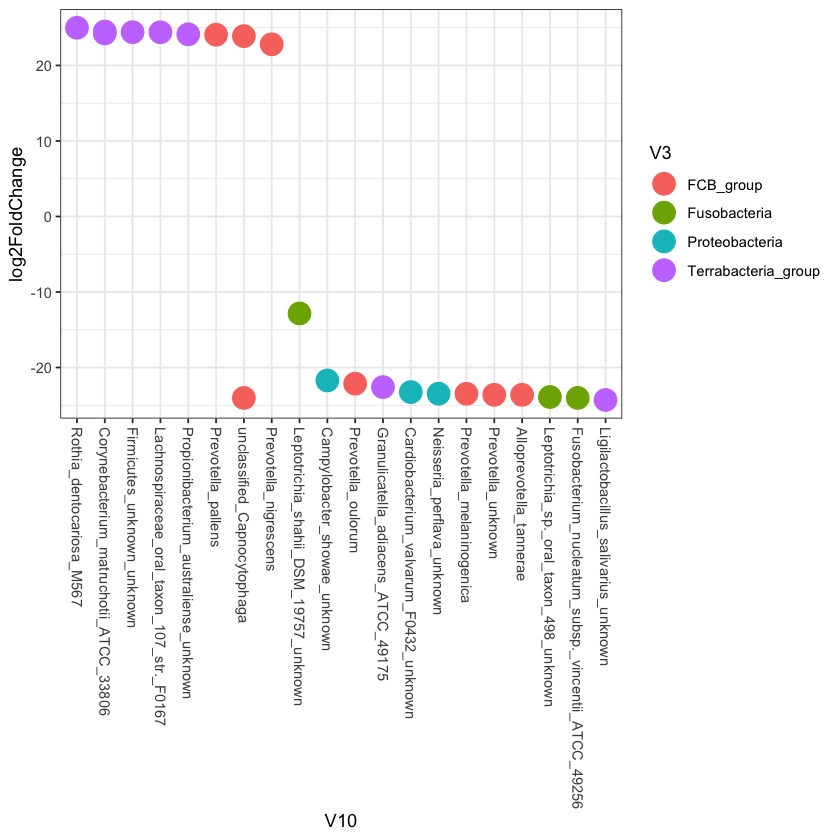

In [19]:
x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 <- factor(as.character(sigtab$V10), levels=names(x))  
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V3)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
pdf("img/deseq_ca-pd_HIvHUU.pdf")
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V3)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
dev.off()

In [20]:
capd <- subset_samples(ps.dat.noUS, aliquot_study == "HI.CA-PD" | aliquot_study == "HEU.CA-PD")
sample_data(capd)$aliquot_study <- as.factor(sample_data(capd)$aliquot_study)
difabund <- phyloseq_to_deseq2(capd, ~ aliquot_study)

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans <- apply(counts(difabund), 1, gm_mean)
difabund <- estimateSizeFactors(difabund, geoMeans = geoMeans)
res <- DESeq(difabund, fitType="local")

sigtab <- results(res)
sigtab <- sigtab[order(sigtab$padj, na.last = NA),]
sigtab <- sigtab[(sigtab$padj < 0.05),]
sigtab <- cbind(as(sigtab, "data.frame"), as(tax_table(cfpf)[rownames(sigtab),], "matrix"))
sigtab

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column nam

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ASV885,16.419212,-26.228227,2.114809,-12.402173,2.543307e-35,1.561591e-32,Bacteria,FCB_group,Bacteroidetes/Chlorobi_group,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,unclassified_Prevotella,Prevotella_sp._oral_taxon_472,Prevotella_sp._oral_taxon_472_str._F0295
ASV583,17.761149,-26.339135,2.734611,-9.631768,5.871058e-22,1.802415e-19,Bacteria,FCB_group,Bacteroidetes/Chlorobi_group,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Capnocytophaga,Capnocytophaga_endodontalis,Capnocytophaga_endodontalis_unknown,Capnocytophaga_endodontalis_unknown
ASV198,10.664683,22.676375,2.418275,9.377086,6.782128e-21,1.388076e-18,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,Neisseria_perflava,Neisseria_perflava_unknown,Neisseria_perflava_unknown,Neisseria_perflava_unknown,Neisseria_perflava_unknown
ASV494,15.486299,23.193666,2.554000,9.081312,1.072743e-19,1.646660e-17,Bacteria,Fusobacteria,Fusobacteriia,Fusobacteriales,Leptotrichiaceae,Leptotrichia,unclassified_Leptotrichia,Leptotrichia_sp._oral_taxon_417,Leptotrichia_sp._oral_taxon_417_unknown,Leptotrichia_sp._oral_taxon_417_unknown,Leptotrichia_sp._oral_taxon_417_unknown
ASV4867,5.994865,-24.855850,2.782113,-8.934161,4.102778e-19,5.038211e-17,Bacteria,Bacteria_incertae_sedis,Bacteria_candidate_phyla,Candidatus_Saccharibacteria,unclassified_Saccharibacteria,Candidatus_Saccharibacteria_bacterium_oral_taxon_488,Candidatus_Saccharibacteria_bacterium_oral_taxon_488_unknown,Candidatus_Saccharibacteria_bacterium_oral_taxon_488_unknown_unknown,Candidatus_Saccharibacteria_bacterium_oral_taxon_488_unknown_unknown,Candidatus_Saccharibacteria_bacterium_oral_taxon_488_unknown_unknown,Candidatus_Saccharibacteria_bacterium_oral_taxon_488_unknown_unknown
ASV957,17.766765,-26.337452,3.064124,-8.595427,8.295566e-18,8.489129e-16,Bacteria,Fusobacteria,Fusobacteriia,Fusobacteriales,Leptotrichiaceae,Leptotrichia,Leptotrichia_shahii,Leptotrichia_shahii_DSM_19757,Leptotrichia_shahii_DSM_19757_unknown,Leptotrichia_shahii_DSM_19757_unknown,Leptotrichia_shahii_DSM_19757_unknown
ASV103,22.555476,21.853170,2.550391,8.568556,1.047910e-17,9.191664e-16,Bacteria,FCB_group,Bacteroidetes/Chlorobi_group,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Capnocytophaga,unclassified_Capnocytophaga,unclassified_Capnocytophaga_unknown,unclassified_Capnocytophaga_unknown
ASV1889,13.473533,-25.961329,3.064220,-8.472410,2.403677e-17,1.639842e-15,Bacteria,Terrabacteria_group,Firmicutes,Clostridia,Eubacteriales,Lachnospiraceae,Catonella,Catonella_morbi,Catonella_morbi_ATCC_51271,Catonella_morbi_ATCC_51271_unknown,Catonella_morbi_ATCC_51271_unknown
ASV388,14.030700,-25.988322,3.064204,-8.481263,2.227626e-17,1.639842e-15,Bacteria,Terrabacteria_group,Firmicutes,Clostridia,Eubacteriales,Lachnospiraceae,Lachnoanaerobaculum,Lachnoanaerobaculum_saburreum,Lachnoanaerobaculum_saburreum_DSM_3986,Lachnoanaerobaculum_saburreum_DSM_3986_unknown,Lachnoanaerobaculum_saburreum_DSM_3986_unknown


pdf 
  2

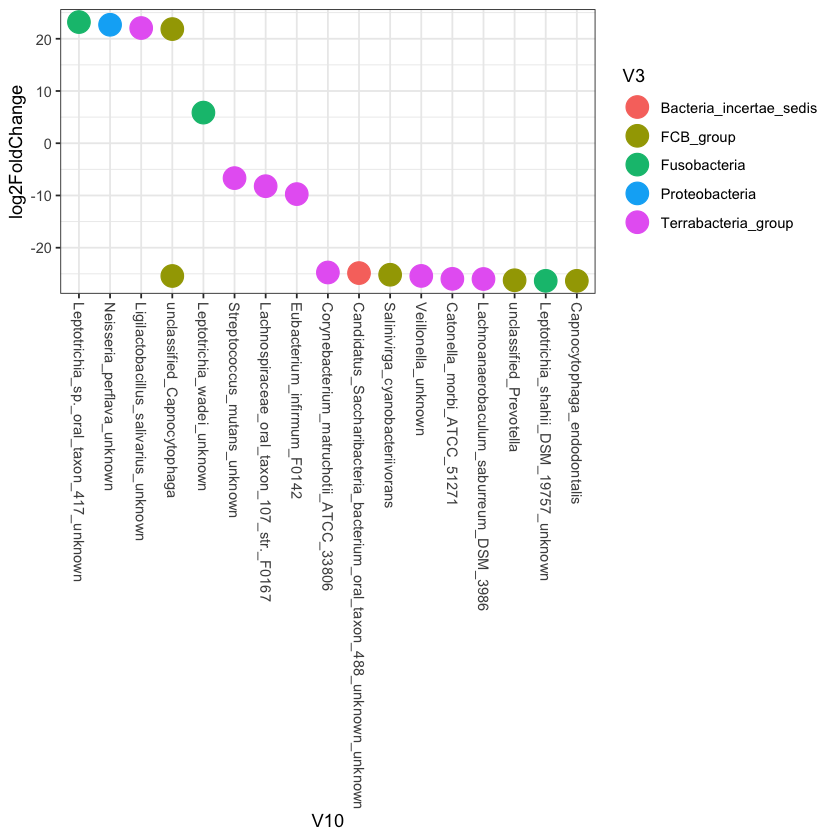

In [21]:
x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V3)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
pdf("img/deseq_ca-pd_HIvHEU.pdf")
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V3)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
dev.off()

In [22]:
capd <- subset_samples(ps.dat.noUS, aliquot_study == "HEU.CA-PD" | aliquot_study == "HUU.CA-PD")
sample_data(capd)$aliquot_study <- as.factor(sample_data(capd)$aliquot_study)
difabund <- phyloseq_to_deseq2(capd, ~ aliquot_study)

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans <- apply(counts(difabund), 1, gm_mean)
difabund <- estimateSizeFactors(difabund, geoMeans = geoMeans)
res <- DESeq(difabund, fitType="local")

sigtab <- results(res)
sigtab <- sigtab[order(sigtab$padj, na.last = NA),]
sigtab <- sigtab[(sigtab$padj < 0.05),]
sigtab <- cbind(as(sigtab, "data.frame"), as(tax_table(capd)[rownames(sigtab),], "matrix"))
sigtab 

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column nam

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ASV885,25.955800,-25.164768,2.125380,-11.840125,2.420925e-32,8.521654e-30,Bacteria,FCB_group,Bacteroidetes/Chlorobi_group,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,unclassified_Prevotella,Prevotella_sp._oral_taxon_472,Prevotella_sp._oral_taxon_472_str._F0295
ASV23,27.312567,-25.243774,2.238374,-11.277729,1.690539e-29,2.975348e-27,Bacteria,Fusobacteria,Fusobacteriia,Fusobacteriales,Leptotrichiaceae,Leptotrichia,unclassified_Leptotrichia,Leptotrichia_sp._oral_taxon_498,Leptotrichia_sp._oral_taxon_498_unknown,Leptotrichia_sp._oral_taxon_498_unknown,Leptotrichia_sp._oral_taxon_498_unknown
ASV166,16.854746,-24.573365,2.250687,-10.918160,9.438875e-28,1.107495e-25,Bacteria,Spirochaetes,Spirochaetia,Spirochaetales,Treponemataceae,Treponema,unclassified_Treponema,Treponema_sp._OMZ_804,Treponema_sp._OMZ_804_unknown,Treponema_sp._OMZ_804_unknown,Treponema_sp._OMZ_804_unknown
ASV256,18.507083,-24.711668,2.406532,-10.268582,9.762905e-25,8.591356e-23,Bacteria,FCB_group,Bacteroidetes/Chlorobi_group,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella_pallens,Prevotella_pallens_ATCC_700821,Prevotella_pallens_ATCC_700821_unknown
ASV1033,11.658427,-24.066987,2.383895,-10.095659,5.774214e-24,4.065047e-22,Bacteria,Terrabacteria_group,Firmicutes,Firmicutes_unknown,Firmicutes_unknown,Firmicutes_unknown,Firmicutes_unknown,Firmicutes_unknown_unknown,Firmicutes_unknown_unknown,Firmicutes_unknown_unknown,Firmicutes_unknown_unknown
ASV124,19.640391,-24.575579,2.550339,-9.636202,5.622973e-22,3.298811e-20,Bacteria,Fusobacteria,Fusobacteriia,Fusobacteriales,Leptotrichiaceae,Leptotrichia,Leptotrichia_buccalis,Leptotrichia_buccalis_C-1013-b,Leptotrichia_buccalis_C-1013-b_unknown,Leptotrichia_buccalis_C-1013-b_unknown,Leptotrichia_buccalis_C-1013-b_unknown
ASV865,18.554386,-24.506568,2.554979,-9.591691,8.665297e-22,4.357407e-20,Bacteria,Fusobacteria,Fusobacteriia,Fusobacteriales,Fusobacteriaceae,Fusobacterium,Fusobacterium_nucleatum,Fusobacterium_nucleatum_subsp._polymorphum,Fusobacterium_nucleatum_subsp._polymorphum_unknown,Fusobacterium_nucleatum_subsp._polymorphum_unknown,Fusobacterium_nucleatum_subsp._polymorphum_unknown
ASV201,15.379465,-24.462101,2.566887,-9.529870,1.574800e-21,6.929121e-20,Bacteria,Fusobacteria,Fusobacteriia,Fusobacteriales,Leptotrichiaceae,Pseudoleptotrichia,Pseudoleptotrichia_goodfellowii,Leptotrichia_goodfellowii_F0264,Leptotrichia_goodfellowii_F0264_unknown,Leptotrichia_goodfellowii_F0264_unknown,Leptotrichia_goodfellowii_F0264_unknown
ASV172,17.491720,-23.484844,2.560458,-9.172126,4.637798e-20,1.813894e-18,Bacteria,FCB_group,Bacteroidetes/Chlorobi_group,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Capnocytophaga,unclassified_Capnocytophaga,Capnocytophaga_sp._oral_taxon_323,Capnocytophaga_sp._oral_taxon_323_unknown


pdf 
  2

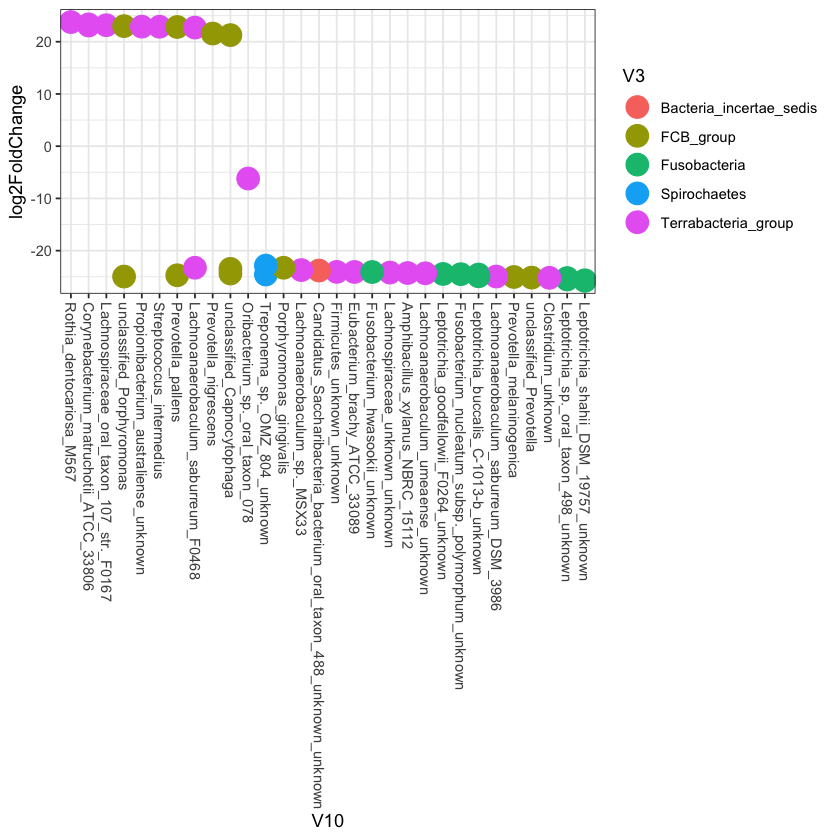

In [23]:
x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V3)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
pdf("deseq_ca-pd_HEUvHUU.pdf")
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V3)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
dev.off()

### 3. Betadiversity of CF-PF and CA-PD

In [24]:
capd <- subset_samples(ps.dat.noUS, aliquot_study == "HI.CA-PD" | aliquot_study == "HUU.CA-PD" | aliquot_study == "HEU.CA-PD")
cfpf <- subset_samples(ps.dat.noUS, aliquot_study == "HI.CF-PF" | aliquot_study == "HUU.CF-PF" | aliquot_study == "HEU.CF-PF")
cape <- subset_samples(ps.dat.noUS, aliquot_study == "HI.CA-PE" | aliquot_study == "HUU.CA-PE" | aliquot_study == "HEU.CA-PE" | aliquot_study == "HI.CAE-PE" | aliquot_study == "HUU.CAE-PE" | aliquot_study == "HEU.CAE-PE")

pdf 
  2

pdf 
  2

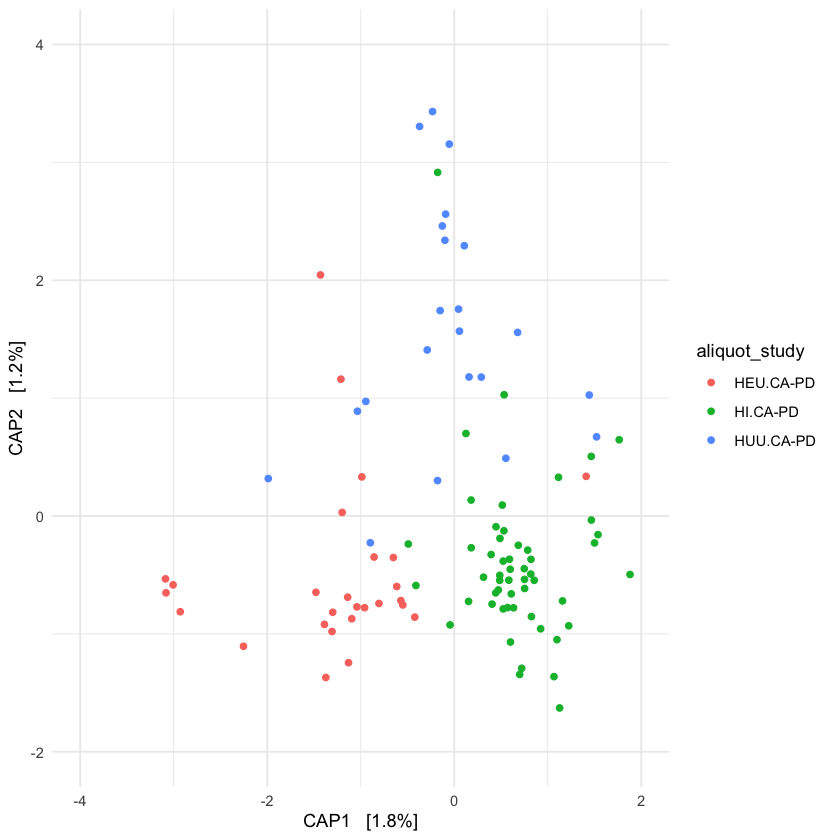

pdf 
  2

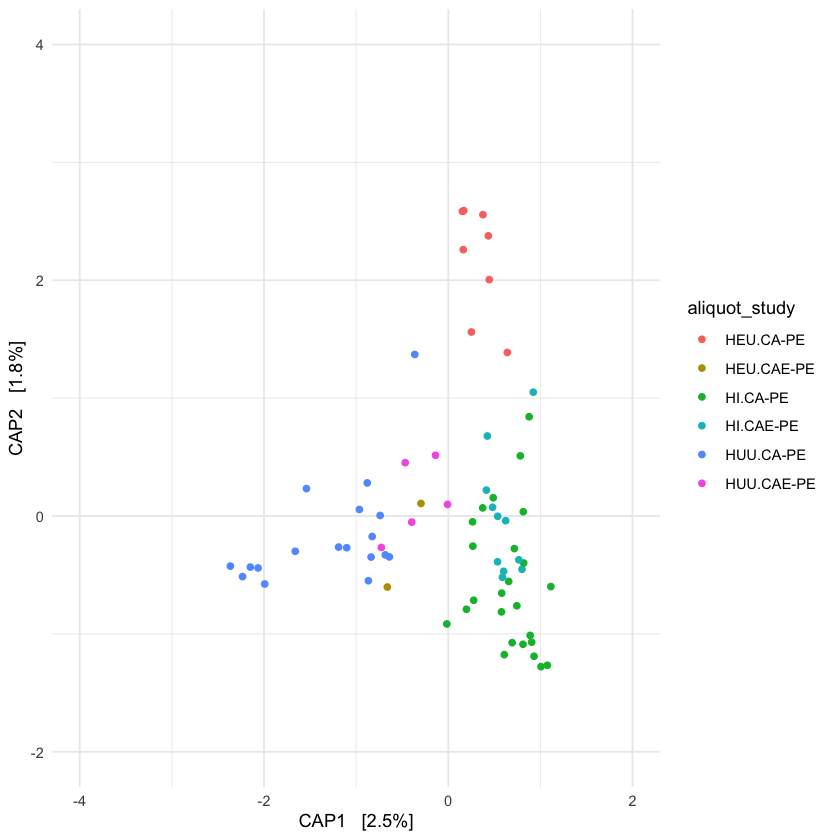

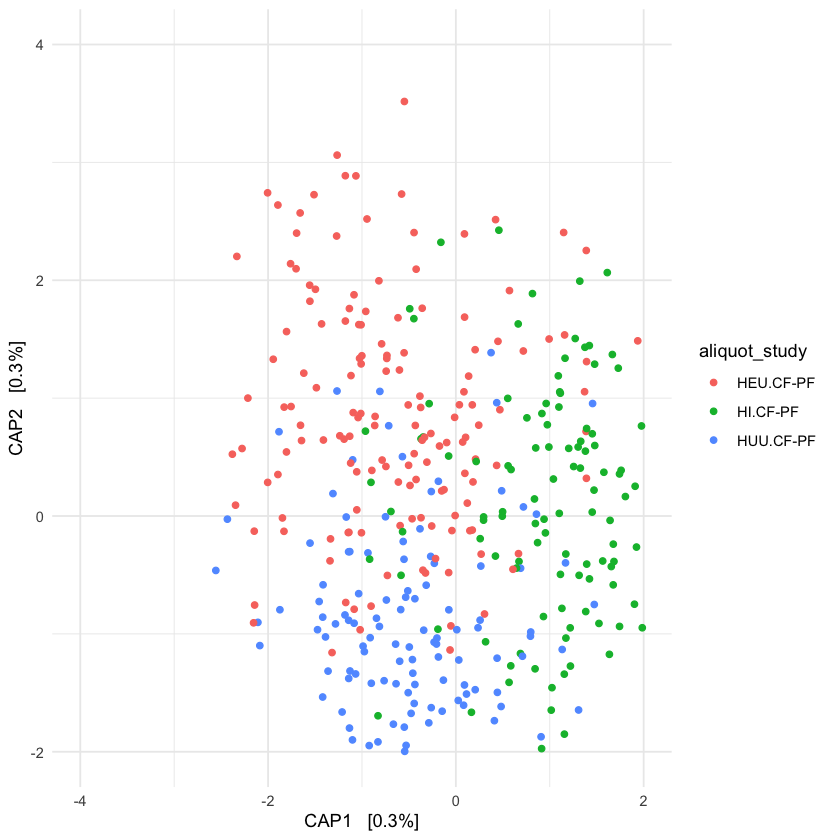

In [25]:
ordcap <- ordinate(capd, "CAP", "bray", ~aliquot_study)
pdf("img/capd_capplot.pdf")
plot_ordination(capd, ordcap, "samples", color="aliquot_study") + theme_minimal() + xlim(c(-4,2)) + ylim(c(-2,4))
dev.off()
plot_ordination(capd, ordcap, "samples", color="aliquot_study") + theme_minimal() + xlim(c(-4,2)) + ylim(c(-2,4))

ordcap <- ordinate(cape, "CAP", "bray", ~aliquot_study)
pdf("img/cape_caepe_capplot.pdf")
plot_ordination(cape, ordcap, "samples", color="aliquot_study") + theme_minimal() + xlim(c(-4,2)) + ylim(c(-2,4))
dev.off()
plot_ordination(cape, ordcap, "samples", color="aliquot_study") + theme_minimal() + xlim(c(-4,2)) + ylim(c(-2,4))

ordcap <- ordinate(cfpf, "CAP", "bray", ~aliquot_study)
pdf("img/cfpf_capplot.pdf")
plot_ordination(cfpf, ordcap, "samples", color="aliquot_study") + theme_minimal() + xlim(c(-4,2)) + ylim(c(-2,4))
dev.off()
plot_ordination(cfpf, ordcap, "samples", color="aliquot_study") + theme_minimal() + xlim(c(-4,2)) + ylim(c(-2,4))

In [26]:
library(vegan)  

# beta dispersion
philr.dat <- transform_sample_counts(cfpf, function(x) x+1) # add pseudocount of one to ASVs to avoid log-ratios calculated from zero
phy_tree(philr.dat) <- makeNodeLabel(phy_tree(philr.dat), method="number", prefix="n")
asv.table <- otu_table(philr.dat)
tree <- phy_tree(philr.dat)
metadata <- sample_data(philr.dat)
tax <- tax_table(philr.dat)
philr.t <- philr(asv.table, tree, part.weights="enorm.x.gm.counts", ilr.weights="blw.sqrt")
philr.dist <- dist(philr.t, method="euclidean")
                                  
vegan::betadisper(philr.dist, phyloseq::sample_data(cfpf)$study_group)
permutest(dispr)
                                     
philr.dat <- transform_sample_counts(cape, function(x) x+1) # add pseudocount of one to ASVs to avoid log-ratios calculated from zero
phy_tree(philr.dat) <- makeNodeLabel(phy_tree(philr.dat), method="number", prefix="n")
asv.table <- otu_table(philr.dat)
tree <- phy_tree(philr.dat)
metadata <- sample_data(philr.dat)
tax <- tax_table(philr.dat)
philr.t <- philr(asv.table, tree, part.weights="enorm.x.gm.counts", ilr.weights="blw.sqrt")
philr.dist <- dist(philr.t, method="euclidean")
                                  
vegan::betadisper(philr.dist, phyloseq::sample_data(cape)$study_group)
permutest(dispr)

philr.dat <- transform_sample_counts(capd, function(x) x+1) # add pseudocount of one to ASVs to avoid log-ratios calculated from zero
phy_tree(philr.dat) <- makeNodeLabel(phy_tree(philr.dat), method="number", prefix="n")
asv.table <- otu_table(philr.dat)
tree <- phy_tree(philr.dat)
metadata <- sample_data(philr.dat)
tax <- tax_table(philr.dat)
philr.t <- philr(asv.table, tree, part.weights="enorm.x.gm.counts", ilr.weights="blw.sqrt")
philr.dist <- dist(philr.t, method="euclidean")
                                  
vegan::betadisper(philr.dist, phyloseq::sample_data(capd)$study_group)
permutest(dispr)                                 

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-2

Building Sequential Binary Partition from Tree...

Building Contrast Matrix...

Transforming the Data...

Calculating ILR Weights...




	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = philr.dist, group =
phyloseq::sample_data(cfpf)$study_group)

No. of Positive Eigenvalues: 416
No. of Negative Eigenvalues: 0

Average distance to median:
  HEU    HI   HUU 
4.735 4.689 4.656 

Eigenvalues for PCoA axes:
(Showing 8 of 416 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
1051.8  723.7  698.8  340.7  225.1  183.3  164.6  151.3 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)
Groups     17  25.96  1.5269 1.3583    999  0.139
Residuals 730 820.59  1.1241                     

Building Sequential Binary Partition from Tree...

Building Contrast Matrix...

Transforming the Data...

Calculating ILR Weights...




	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = philr.dist, group =
phyloseq::sample_data(cape)$study_group)

No. of Positive Eigenvalues: 68
No. of Negative Eigenvalues: 0

Average distance to median:
  HEU    HI   HUU 
7.046 6.755 7.424 

Eigenvalues for PCoA axes:
(Showing 8 of 68 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
670.2 366.1 233.0 190.8 150.0 148.2 125.8 117.9 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)
Groups     17  25.96  1.5269 1.3583    999   0.17
Residuals 730 820.59  1.1241                     

Building Sequential Binary Partition from Tree...

Building Contrast Matrix...

Transforming the Data...

Calculating ILR Weights...




	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = philr.dist, group =
phyloseq::sample_data(capd)$study_group)

No. of Positive Eigenvalues: 101
No. of Negative Eigenvalues: 0

Average distance to median:
  HEU    HI   HUU 
6.572 6.364 6.487 

Eigenvalues for PCoA axes:
(Showing 8 of 101 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
841.7 346.3 330.9 219.2 195.1 133.9 120.5 112.9 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)
Groups     17  25.96  1.5269 1.3583    999  0.146
Residuals 730 820.59  1.1241                     

In [77]:
# first need to split our aliqout type variable into two
library(stringr)
phyloseq::sample_data(ps.dat.noUS)[c('oralhealth', 'toothhealth')] <- str_split_fixed(phyloseq::sample_data(ps.dat.noUS)$aliquot_type, '-', 2)

philr.dat <- transform_sample_counts(ps.dat.noUS, function(x) x+1) # add pseudocount of one to ASVs to avoid log-ratios calculated from zero
phy_tree(philr.dat) <- makeNodeLabel(phy_tree(philr.dat), method="number", prefix="n")
asv.table <- otu_table(philr.dat)
tree <- phy_tree(philr.dat)
metadata <- sample_data(philr.dat)
tax <- tax_table(philr.dat)
philr.t <- philr(asv.table, tree, part.weights="enorm.x.gm.counts", ilr.weights="blw.sqrt")
philr.dist <- dist(philr.t, method="euclidean")
                                  
vegan::betadisper(philr.dist, phyloseq::sample_data(ps.dat.noUS)$toothhealth)
permutest(dispr)                                 

Building Sequential Binary Partition from Tree...

Building Contrast Matrix...

Transforming the Data...

Calculating ILR Weights...




	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = philr.dist, group =
phyloseq::sample_data(ps.dat.noUS)$toothhealth)

No. of Positive Eigenvalues: 747
No. of Negative Eigenvalues: 0

Average distance to median:
   PD    PE    PF 
4.138 4.075 4.215 

Eigenvalues for PCoA axes:
(Showing 8 of 747 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
1713.3  864.5  834.2  421.7  313.9  241.5  210.9  197.5 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)
Groups     17  25.96  1.5269 1.3583    999  0.138
Residuals 730 820.59  1.1241                     

In [57]:
# what about by group?
hi <- subset_samples(ps.dat.noUS, study_group=="HI")
heu <- subset_samples(ps.dat.noUS, study_group=="HEU")
huu <- subset_samples(ps.dat.noUS, study_group=="HUU")

philr.dat <- transform_sample_counts(hi, function(x) x+1) # add pseudocount of one to ASVs to avoid log-ratios calculated from zero
phy_tree(philr.dat) <- makeNodeLabel(phy_tree(philr.dat), method="number", prefix="n")
asv.table <- otu_table(philr.dat)
tree <- phy_tree(philr.dat)
metadata <- sample_data(philr.dat)
tax <- tax_table(philr.dat)
philr.t <- philr(asv.table, tree, part.weights="enorm.x.gm.counts", ilr.weights="blw.sqrt")
philr.dist <- dist(philr.t, method="euclidean")
                                  
vegan::betadisper(philr.dist, phyloseq::sample_data(hi)$toothhealth)
permutest(dispr)   
                                     
philr.dat <- transform_sample_counts(heu, function(x) x+1) # add pseudocount of one to ASVs to avoid log-ratios calculated from zero
phy_tree(philr.dat) <- makeNodeLabel(phy_tree(philr.dat), method="number", prefix="n")
asv.table <- otu_table(philr.dat)
tree <- phy_tree(philr.dat)
metadata <- sample_data(philr.dat)
tax <- tax_table(philr.dat)
philr.t <- philr(asv.table, tree, part.weights="enorm.x.gm.counts", ilr.weights="blw.sqrt")
philr.dist <- dist(philr.t, method="euclidean")
                                  
vegan::betadisper(philr.dist, phyloseq::sample_data(heu)$toothhealth)
permutest(dispr)   
                                     
philr.dat <- transform_sample_counts(huu, function(x) x+1) # add pseudocount of one to ASVs to avoid log-ratios calculated from zero
phy_tree(philr.dat) <- makeNodeLabel(phy_tree(philr.dat), method="number", prefix="n")
asv.table <- otu_table(philr.dat)
tree <- phy_tree(philr.dat)
metadata <- sample_data(philr.dat)
tax <- tax_table(philr.dat)
philr.t <- philr(asv.table, tree, part.weights="enorm.x.gm.counts", ilr.weights="blw.sqrt")
philr.dist <- dist(philr.t, method="euclidean")
                                  
vegan::betadisper(philr.dist, phyloseq::sample_data(huu)$toothhealth)
permutest(dispr) 

Building Sequential Binary Partition from Tree...

Building Contrast Matrix...

Transforming the Data...

Calculating ILR Weights...




	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = philr.dist, group =
phyloseq::sample_data(hi)$toothhealth)

No. of Positive Eigenvalues: 293
No. of Negative Eigenvalues: 0

Average distance to median:
   PD    PE    PF 
5.065 4.867 5.407 

Eigenvalues for PCoA axes:
(Showing 8 of 293 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
1647.4  659.1  609.7  297.2  195.7  175.0  152.2  142.6 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)
Groups     17  25.96  1.5269 1.3583    999  0.143
Residuals 730 820.59  1.1241                     

Building Sequential Binary Partition from Tree...

Building Contrast Matrix...

Transforming the Data...

Calculating ILR Weights...




	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = philr.dist, group =
phyloseq::sample_data(heu)$toothhealth)

No. of Positive Eigenvalues: 223
No. of Negative Eigenvalues: 0

Average distance to median:
   PD    PE    PF 
5.163 5.001 5.321 

Eigenvalues for PCoA axes:
(Showing 8 of 223 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
717.1 462.6 371.0 279.0 200.7 154.6 144.1 134.1 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)
Groups     17  25.96  1.5269 1.3583    999  0.141
Residuals 730 820.59  1.1241                     

Building Sequential Binary Partition from Tree...

Building Contrast Matrix...

Transforming the Data...

Calculating ILR Weights...




	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = philr.dist, group =
phyloseq::sample_data(huu)$toothhealth)

No. of Positive Eigenvalues: 229
No. of Negative Eigenvalues: 0

Average distance to median:
   PD    PE    PF 
5.355 5.491 5.382 

Eigenvalues for PCoA axes:
(Showing 8 of 229 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
1002.0  630.5  460.4  257.0  183.5  174.1  140.7  132.9 


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df Sum Sq Mean Sq      F N.Perm Pr(>F)
Groups     17  25.96  1.5269 1.3583    999  0.169
Residuals 730 820.59  1.1241                     

In [75]:
# since there are sample size differences that are driving dispersion estimates, try running Sorensen dissimilarity
# install.packages("betapart")
library(betapart)

x <- otu_table(capd)
x <- as.data.frame(x)
# convert to presence/absence for sorensen distance
x[x>0] <- 1
head(x)

beta.multi(x, index.family = "sorensen")



,ASV5406,ASV247,ASV582,ASV1733,ASV504,ASV129,ASV1322,ASV1370,ASV4896,ASV2700,⋯,ASV8216,ASV3506,ASV1758,ASV95,ASV542,ASV1006,ASV4838,ASV1107,ASV1588,ASV2629
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,⋯,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
DM00013V1PQ65-3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
DM00013V1PQ83-2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
DM00014V1PQ64-2,0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
DM00014V1PQ84-1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
DM00018V1PQ75-1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
DM00021V1PQ55-1,0,0,0,0,0,0,0,0,0,0,⋯,0,1,0,1,0,0,0,0,0,0


$beta.SIM
[1] 0.9759892

$beta.SNE
[1] 0.007682371

$beta.SOR
[1] 0.9836716

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column nam

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ASV48,4.759455,-25.16062,2.891319,-8.702125,3.257251e-18,8.533997e-15,Bacteria,FCB_group,Bacteroidetes/Chlorobi_group,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella_oralis,Prevotella_oralis_unknown,Prevotella_oralis_unknown


pdf 
  2

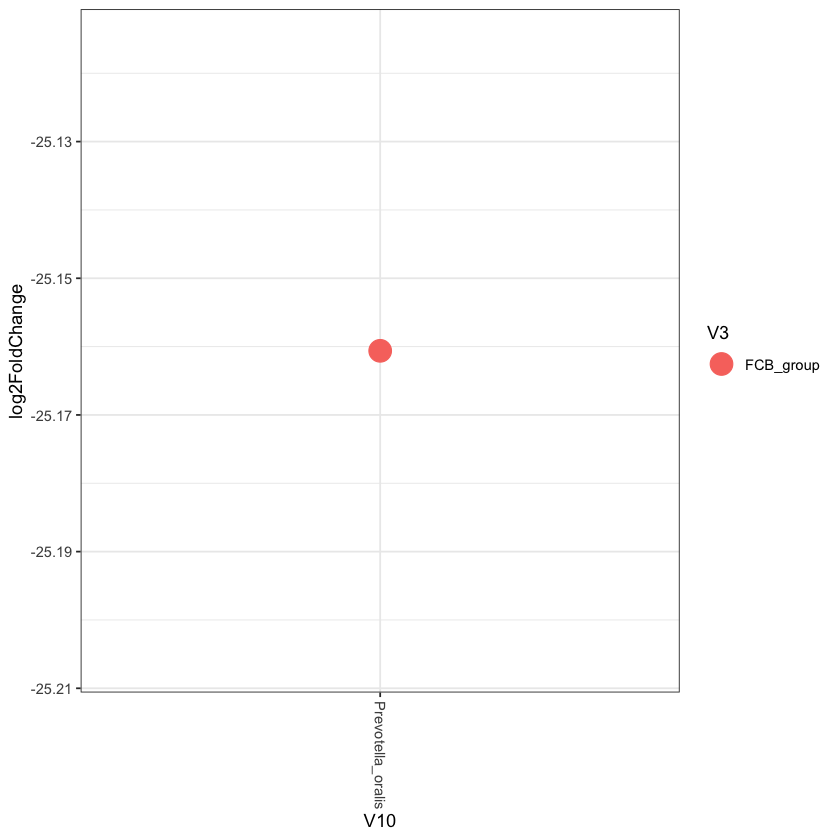

In [27]:
cfpf <- subset_samples(ps.dat.noUS, aliquot_study == "HI.CF-PF" | aliquot_study == "HUU.CF-PF")
sample_data(cfpf)$aliquot_study <- as.factor(sample_data(cfpf)$aliquot_study)
difabund <- phyloseq_to_deseq2(cfpf, ~ aliquot_study)

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans <- apply(counts(difabund), 1, gm_mean)
difabund <- estimateSizeFactors(difabund, geoMeans = geoMeans)
res <- DESeq(difabund, fitType="local")

sigtab <- results(res)
sigtab <- sigtab[order(sigtab$padj, na.last = NA),]
sigtab <- sigtab[(sigtab$padj < 0.05),]
sigtab <- cbind(as(sigtab, "data.frame"), as(tax_table(cfpf)[rownames(sigtab),], "matrix"))
sigtab

x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V3)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
pdf("deseq_cf-pf_HIvHUU.pdf")
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V3)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
dev.off()

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column nam

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ASV150,10.384670,-26.12321,1.886049,-13.850757,1.258780e-43,3.337025e-40,Bacteria,FCB_group,Bacteroidetes/Chlorobi_group,Bacteroidetes,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Capnocytophaga,Capnocytophaga_gingivalis,Capnocytophaga_gingivalis_unknown,Capnocytophaga_gingivalis_unknown
ASV71,13.978809,-26.15632,2.898233,-9.024918,1.798295e-19,2.383640e-16,Bacteria,Fusobacteria,Fusobacteriia,Fusobacteriales,Leptotrichiaceae,Leptotrichia,unclassified_Leptotrichia,Leptotrichia_sp._oral_taxon_417,Leptotrichia_sp._oral_taxon_417_unknown,Leptotrichia_sp._oral_taxon_417_unknown,Leptotrichia_sp._oral_taxon_417_unknown
ASV120,8.086232,25.32706,2.897574,8.740783,2.315009e-18,2.045696e-15,Bacteria,Terrabacteria_group,Actinobacteria,Actinomycetia,Corynebacteriales,Corynebacteriaceae,Corynebacterium,Corynebacterium_matruchotii,Corynebacterium_matruchotii_ATCC_33806,Corynebacterium_matruchotii_ATCC_33806_unknown,Corynebacterium_matruchotii_ATCC_33806_unknown


pdf 
  2

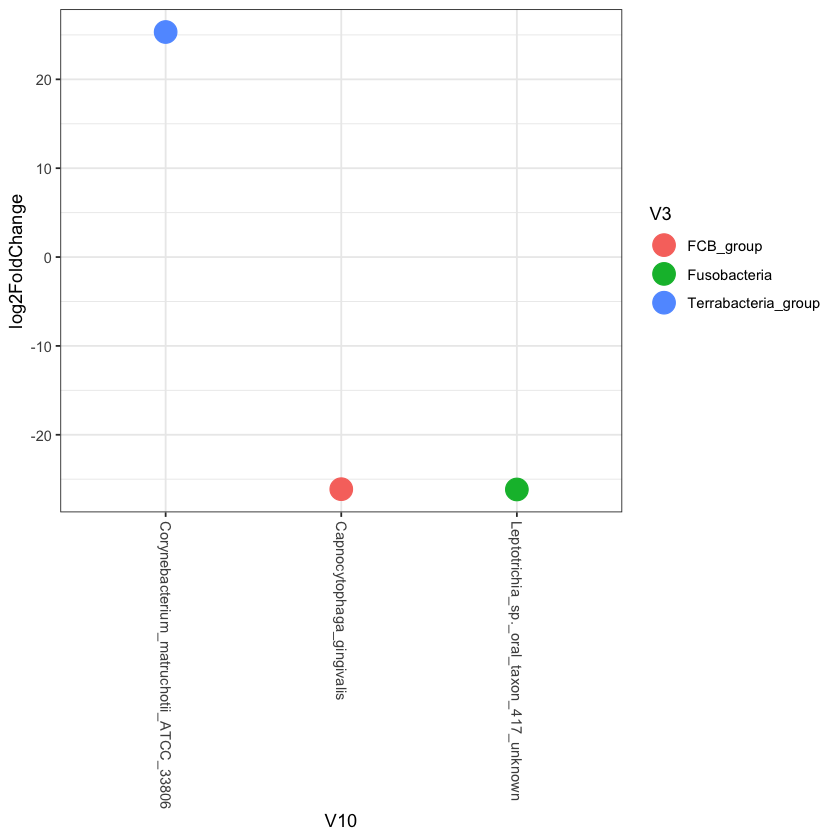

In [28]:
cfpf <- subset_samples(ps.dat.noUS, aliquot_study == "HI.CF-PF" | aliquot_study == "HEU.CF-PF")
sample_data(cfpf)$aliquot_study <- as.factor(sample_data(cfpf)$aliquot_study)
difabund <- phyloseq_to_deseq2(cfpf, ~ aliquot_study)

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans <- apply(counts(difabund), 1, gm_mean)
difabund <- estimateSizeFactors(difabund, geoMeans = geoMeans)
res <- DESeq(difabund, fitType="local")

sigtab <- results(res)
sigtab <- sigtab[order(sigtab$padj, na.last = NA),]
sigtab <- sigtab[(sigtab$padj < 0.05),]
sigtab <- cbind(as(sigtab, "data.frame"), as(tax_table(cfpf)[rownames(sigtab),], "matrix"))
sigtab

x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V3)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
pdf("deseq_cf-pf_HIvHEU.pdf")
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V3)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
dev.off()

In [29]:
cfpf <- subset_samples(ps.dat.noUS, aliquot_study == "HEU.CF-PF" | aliquot_study == "HUU.CF-PF")
sample_data(cfpf)$aliquot_study <- as.factor(sample_data(cfpf)$aliquot_study)
difabund <- phyloseq_to_deseq2(cfpf, ~ aliquot_study)

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans <- apply(counts(difabund), 1, gm_mean)
difabund <- estimateSizeFactors(difabund, geoMeans = geoMeans)
res <- DESeq(difabund, fitType="local")

sigtab <- results(res)
sigtab <- sigtab[order(sigtab$padj, na.last = NA),]
sigtab <- sigtab[(sigtab$padj < 0.05),]
sigtab <- cbind(as(sigtab, "data.frame"), as(tax_table(cfpf)[rownames(sigtab),], "matrix"))
sigtab

x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$V10, function(x) max(x))
x = sort(x, TRUE)
sigtab$V10 = factor(as.character(sigtab$V10), levels=names(x))
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V3)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
pdf("deseq_cf-pf_HEUvHUU.pdf")
ggplot(sigtab, aes(x=V10, y=log2FoldChange, color=V3)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
dev.off()

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column nam

ERROR: Error in dimnames(x) <- dn: length of 'dimnames' [1] not equal to array extent


In [ ]:
sigtab